This notebook expects a previows data processing pipeline, that defines four variables: `X_train`, `X_test`, `y_train`, `y_test`



In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
#import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("../data_ign/Month_Value_1.csv")
df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [3]:
X = df.iloc[:, 2:].copy()  # Selecting appropriate features, excluding 'Period' and 'Revenue'
y = df['Revenue'].copy().values.reshape(-1, 1)  # Target

In [4]:
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

In [5]:
#first 60 for training

X_train = X_ss[:60, :]
X_test = X_ss[60:, :]

y_train = y_mm[:60, :]
y_test = y_mm[60:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (60, 3) (60, 1)
Testing Shape (36, 3) (36, 1)


In [6]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([60, 1, 3]) torch.Size([60, 1])
Testing Shape torch.Size([36, 1, 3]) torch.Size([36, 1])


In [7]:
class PolynomialRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(PolynomialRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        if x.dim() == 3 and x.size(1) == 1:
            x = x.squeeze(1)
        out = self.linear(x)
        return out


In [8]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked linear layers

num_classes = 1 #number of output classes



In [9]:
poly = PolynomialRegressionModel(X_train_tensors.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(poly.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  outputs = poly.forward(X_train_tensors) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.80708
Epoch: 100, loss: 0.57698
Epoch: 200, loss: 0.40536
Epoch: 300, loss: 0.27977
Epoch: 400, loss: 0.18957
Epoch: 500, loss: 0.12598
Epoch: 600, loss: 0.08199
Epoch: 700, loss: 0.05214
Epoch: 800, loss: 0.03235
Epoch: 900, loss: 0.01955


In [10]:
df_X_ss = ss.transform(X)  # Transform features
df_y_mm = mm.transform(y)  # Transform target

# Convert to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

# Reshape the dataset to the format (batch_size, seq_length, input_size)
#df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

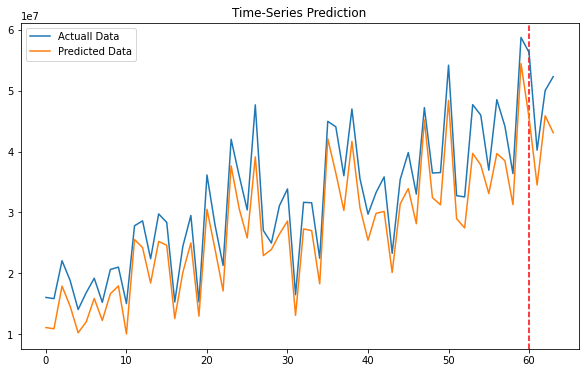

In [12]:
train_predict = poly(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=60, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()